In [30]:
import numpy as np
import matplotlib.pyplot as plt

class BernoulliMultiArmedBandit:
    """
    A multi-armed bandit with Bernoulli-distributed rewards.
    """
    def __init__(self, K):
        self.K = K # number of arms
        self.probs = np.random.uniform(size=K) # true success probabilities for each arm
        self.best_idx = np.argmax(self.probs) # index of the best arm
        self.best_prob = self.probs[self.best_idx] # best success probability

    def pull(self, k):
        """
        Simulate pulling arm k.
        Returns 1 with probability probs[k], else returns 0.
        """
        return 1 if np.random.rand() < self.probs[k] else 0


np.random.seed(1) # for reproducibility
K = 10
bandit_10_arm = BernoulliMultiArmedBandit(K)
print("%d armed bandit" % K)
print("Max prob arm is %d with prob %.4f" % (bandit_10_arm.best_idx, bandit_10_arm.best_prob))


10 armed bandit
Max prob arm is 1 with prob 0.7203


In [31]:
class Solver:
    """
    Base class for multi-armed bandit solvers.
    """
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(bandit.K) # number of times each arm was pulled
        self.regret_sum = 0 # cumulative regret
        self.actions = [] # history of actions taken
        self.regrets = [] # history of accumulated regrets

    def updates_regret_sum(self, K):
        self.regret_sum += self.bandit.best_prob - self.bandit.probs[K]
        self.regrets.append(self.regret_sum)

    def run_one_step(self):
        raise NotImplementedError("This method should be overridden by subclasses.")
    
    def run(self, num_steps):
        for _ in range(num_steps):
            k = self.run_one_step()
            self.actions.append(k)
            self.counts[k] += 1
            self.updates_regret_sum(k)

In [32]:
### static epsilon-greedy
class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super().__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.full(bandit.K, init_prob) # intial estimated success probabilities of k arms

    def run_one_step(self):
        if np.random.rand() < self.epsilon: # explore
            k = np.random.choice(self.bandit.K) # choose an arm randomly
        else: # exploit
            k = np.argmax(self.estimates) # choose the arm with the highest estimated success probability
        reward = self.bandit.pull(k) # pull the chosen arm
        self.estimates[k] += 1. / (self.counts[k] + 1) * (reward - self.estimates[k]) # update the estimated success probability for arm k
        
        return k

In [33]:
def plot_results(solvers, solvers_names):
    for idx, solver in enumerate(solvers): # traverse different solvers
        time_list = range(len(solver.regrets)) # get the time steps
        plt.plot(time_list, solver.regrets, label=solvers_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative Regret')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

Epsilon-Greedy, cumulative regret: 25.526630933945313


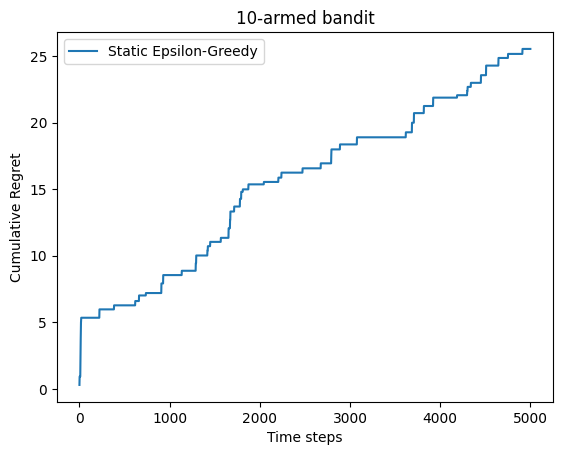

In [34]:
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm)
epsilon_greedy_solver.run(5000)
print('Epsilon-Greedy, cumulative regret:', epsilon_greedy_solver.regret_sum)
plot_results([epsilon_greedy_solver], ['Static Epsilon-Greedy'])

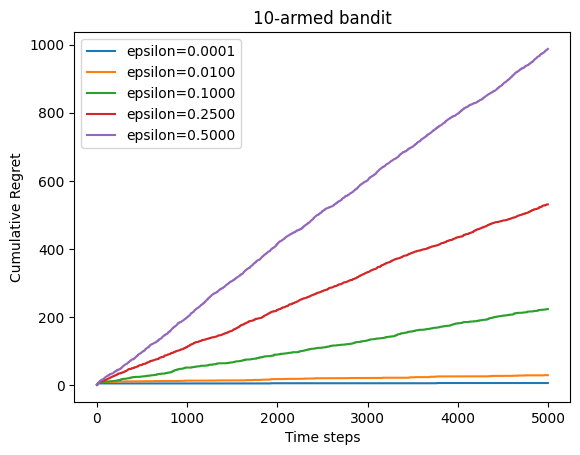

In [40]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=eps) for eps in epsilons
]
epsilon_greedy_solver_names = ['epsilon=%.4f' % eps for eps in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

In [41]:
### Decaying epsilon-greedy
class DecayingEpsilonGreedy(Solver):
    def __init__(self, bandit, init_prob=1.0):
        super().__init__(bandit)
        self.estimates = np.full(bandit.K, init_prob)
        self.total_counts = 0 # total number of pulls across all arms

    def run_one_step(self):
        self.total_counts += 1
        if np.random.rand() < 1. / self.total_counts: # explore with decaying probability
            k = np.random.choice(self.bandit.K)
        else: # exploit
            k = np.argmax(self.estimates)

        reward = self.bandit.pull(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (reward - self.estimates[k])

        return k

Decaying Epsilon-Greedy, cumulative regret: 10.114334931260183


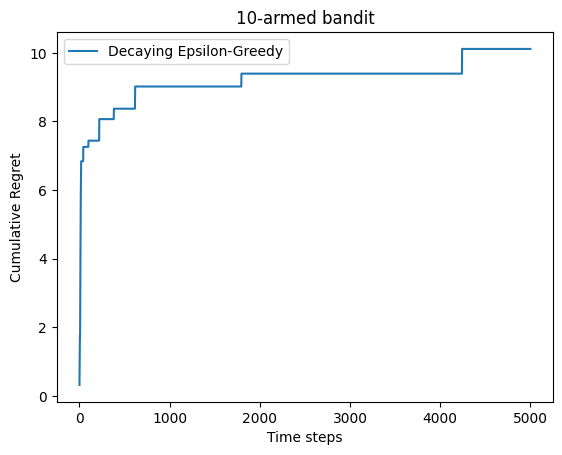

In [42]:
np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('Decaying Epsilon-Greedy, cumulative regret:', decaying_epsilon_greedy_solver.regret_sum)
plot_results([decaying_epsilon_greedy_solver], ['Decaying Epsilon-Greedy'])

In [43]:
### upper confidence bound
class UCB(Solver):
    def __init__(self, bandit, coef, init_prob=1.0):
        super().__init__(bandit)
        self.total_count = 0
        self.estimates = np.full(bandit.K, init_prob)
        self.coef = coef # coefficient for the term of uncertainty

    def run_one_step(self):
        self.total_count += 1
        ucb_values = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1))) # p = 1 / t, error term decreases as t increases, the confidence of the estimate increases
        k = np.argmax(ucb_values) # choose the arm with the highest UCB
        reward = self.bandit.pull(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (reward - self.estimates[k])

        return k

UCB, cumulative regret: 70.45281214197854


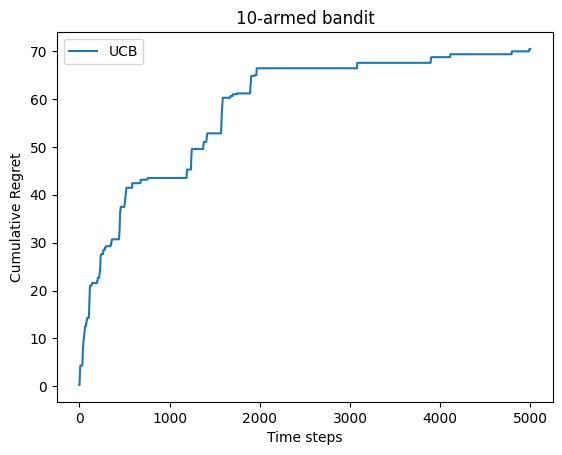

In [44]:
np.random.seed(1)
coef = 1
ucb_solver = UCB(bandit_10_arm, coef)
ucb_solver.run(5000)
print('UCB, cumulative regret:', ucb_solver.regret_sum)
plot_results([ucb_solver], ['UCB'])

In [45]:
### Thompson Sampling
class ThompsonSampling(Solver):
    def __init__(self, bandit):
        super().__init__(bandit)
        self.successes = np.zeros(bandit.K) # number of successes for each arm
        self.failures = np.zeros(bandit.K) # number of failures for each arm

    def run_one_step(self):
        samples = np.random.beta(self.successes + 1, self.failures + 1) # sample from the beta distribution for each arm
        k = np.argmax(samples) # choose the arm with the highest sampled theta
        reward = self.bandit.pull(k)
        
        self.successes[k] += reward
        self.failures[k] += 1 - reward

        return k

Thompson Sampling, cumulative regret: 57.19161964443925


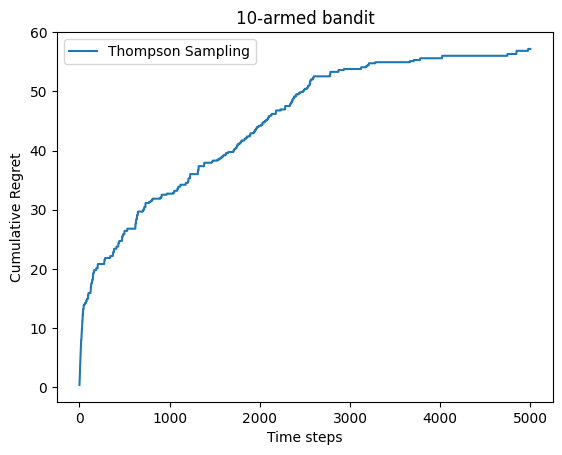

In [46]:
np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('Thompson Sampling, cumulative regret:', thompson_sampling_solver.regret_sum)
plot_results([thompson_sampling_solver], ['Thompson Sampling'])